In [44]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm 

In [45]:
# Define Variables Here and check Device
batch_size = 64
learning_rate = 0.001
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}')

# Train and Test Data 
train_data = datasets.FashionMNIST(root = 'data',train=True, download = True, transform = ToTensor())
test_data = datasets.FashionMNIST(root = 'data', train=False, download = True, transform = ToTensor())

# Train and Test Data Loaders
train_dataloader = DataLoader(train_data, batch_size = batch_size)
test_dataloader = DataLoader(test_data, batch_size = batch_size)

Using cuda


### Check the Dataset by Displaying Few Images with labels

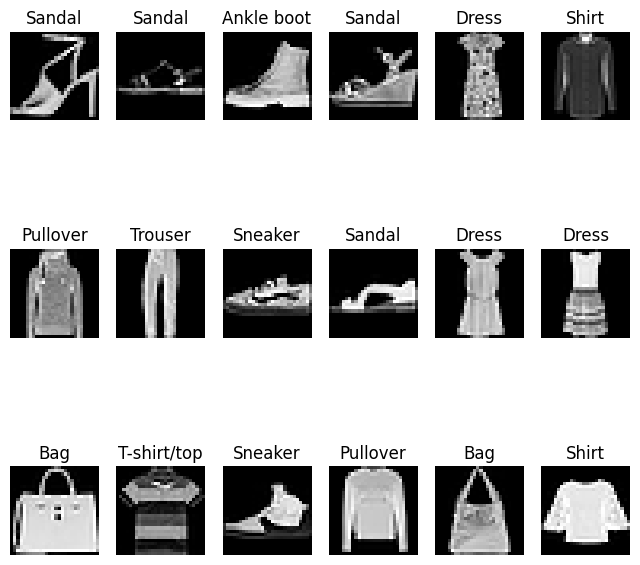

In [46]:
rand_ids = np.random.randint(1,len(train_data),18)
labels = train_data.classes
figure = plt.figure(figsize=(8,8))
i = 1
for id in rand_ids:
    img, label = train_data[id]
    figure.add_subplot(3, 6, i)
    plt.title(labels[label])
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap = 'gray')
    i+=1
plt.show()

### Create the Model / Classifier

In [47]:
# Create a CNN Model Here

class ModelCnn(nn.Module):
    def __init__(self):
        super(ModelCnn, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.fc1 = nn.Linear(64 * 6 * 6, 600)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(600, 120)
        self.fc3 = nn.Linear(120, 10)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out


model = ModelCnn().to(device)
print(model)
        
loss_fn = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)  

ModelCnn(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
  (relu): ReLU()
)


## Creating a Train Loop 

In [48]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    train_acc, train_loss = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        #Computer prediction error
        pred = model(X)
        
        # calculate correct accuracy
        train_acc = (pred.argmax(1) == y).type(torch.float).sum().item()
        train_acc = float(train_acc * 100/y.shape[0])
        
        #calculate loss value
        train_loss = loss_fn(pred, y)
        
        #Backpropogation
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
       
    print(f'Train Accuracy : {train_acc:.2f}%, Train loss: {train_loss:.2f}')

## Creating a Test Loop

In [49]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_acc, test_loss,correct = 0,0,0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            
            # Calculate Test accuracy
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
            # calculate Test loss
            test_loss += loss_fn(pred, y).item()
            

    test_acc = correct/size
    test_loss /= num_batches
   
    print(f"Test  Accuracy: {100 * test_acc:>.2f}%, Test  loss: {test_loss:>.2f}\n")
    

In [50]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1-------------------------------
Train Accuracy : 87.50%, Train loss: 0.42
Test  Accuracy: 86.04%, Test  loss: 0.39

Epoch 2-------------------------------
Train Accuracy : 93.75%, Train loss: 0.21
Test  Accuracy: 88.71%, Test  loss: 0.31

Epoch 3-------------------------------
Train Accuracy : 93.75%, Train loss: 0.16
Test  Accuracy: 89.46%, Test  loss: 0.30

Epoch 4-------------------------------
Train Accuracy : 96.88%, Train loss: 0.11
Test  Accuracy: 89.26%, Test  loss: 0.31

Epoch 5-------------------------------
Train Accuracy : 93.75%, Train loss: 0.11
Test  Accuracy: 89.42%, Test  loss: 0.32

Epoch 6-------------------------------
Train Accuracy : 96.88%, Train loss: 0.11
Test  Accuracy: 88.02%, Test  loss: 0.38

Epoch 7-------------------------------
Train Accuracy : 93.75%, Train loss: 0.11
Test  Accuracy: 89.18%, Test  loss: 0.35

Epoch 8-------------------------------
Train Accuracy : 96.88%, Train loss: 0.10
Test  Accuracy: 89.82%, Test  loss: 0.33

Epoch 9---------

In [51]:
len(test_dataloader.dataset)

10000

# Model Prediction


Correctely Classified 91.67%


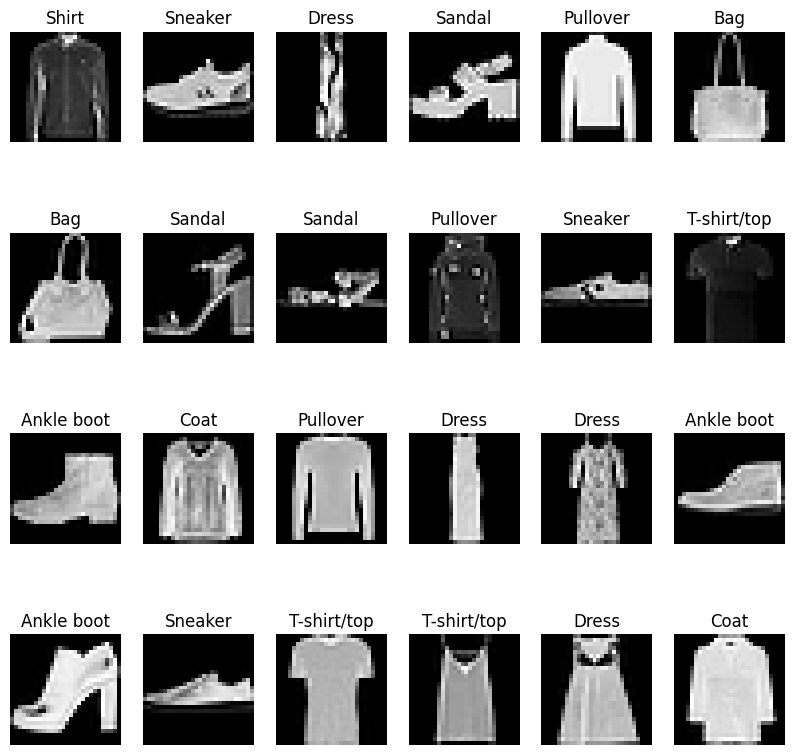

In [52]:
rand_ids = np.random.randint(1,len(test_data),24)
labels = test_data.classes
figure = plt.figure(figsize=(10,10))
i = 1
model.eval()
correct = 0
with torch.no_grad():
    for id in rand_ids:
        x, y = test_data[id][0], test_data[id][1]
        x = x.to(device)
        pred = model(x.unsqueeze(0))
        figure.add_subplot(4, 6, i)
        plt.title(labels[pred.argmax(1).item()])
        plt.axis('off')
        plt.imshow(x[0].cpu().squeeze(), cmap = 'gray')
        i+=1
        if(y == pred.argmax(1).item()):
            correct +=1
print(f"Correctely Classified {correct * 100/len(rand_ids):>.2f}%")
plt.show()